# Digital acceptance testing

Goal is to make it easy to modify f-eng configuration while recording data.

1. Write MS file
- set all inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps

2. Write beamformed data
- set inputs to zeros
- set pol a inputs to adc, then pol b to adc
- set eq coeffs to zero for first ten channels on first snap, then iterate through all snaps
3. Read autos from MS file
- confirm order of zeros, adc on pol on sequence, channel off sequence, and antennas off sequence
4. Read beamformed data
- confirm order of zeros, adc on pol order, channel off order by channel

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa_antpos import mapping
import casacore.tables

Read antpos from etcd


In [2]:
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, DataRange1d, Select
from bokeh.palettes import Viridis
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [3]:
snap2names = [f'snap{i:02}' for i in range(1, 12)]

def set_input(mode='use_zero', stream=None, pol=None, names=snap2names):
    """ Set the input block method
    mode can be "use_zero", "use_adc", "use_noise", "zero_coeffs",
    "reset_coeffs", "get_status".
    """

    if isinstance(names, str):
        names = [names]

    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        num = int(name.lstrip('snap'))

        if (pol is None) or isinstance(stream, int):
            print(f"Set stream: {stream}")
            run(f, stream, mode=mode)
        elif (stream is None) and (pol is not None):
            antpols = []
            if pol == 'a':
                inps = list(range(0,64,2))
            elif pol == 'b':
                inps = list(range(1,64,2))
            for inp in inps:
                antpols.append(mapping.snap2_to_antpol(num, inp))
                run(f, inp, mode=mode)
            print(f"Set antpols {antpols}")

def run(f, stream, mode='use_zero', zerochans=range(0, 5)):
    if mode == 'use_zero':
        f.input.use_zero(stream)
    elif mode == 'use_adc':
        f.input.use_adc(stream)
    elif mode == 'use_noise':
        f.input.use_noise(stream)
    elif mode == 'get_status':
        print('input status:')
        f.input.get_status()
        print('eqtvg status:')
        f.eqtvg.get_status()
    elif mode == 'reset_coeffs':
        f.eq.initialize(read_only=False)
    elif mode == 'zero_coeffs':
        for i in range(64):
            coeffs, scalefactor = f.eq.get_coeffs(i)
            # [1] is scale factor (coeff binary point), coeff = 9600/2**scalefactor?
            coeffs2 = coeffs >> zeropoint
            coeffs2[:5] = 0
            f.eq.set_coeffs(i, coeffs=coeffs2)
    else:
        print(f'mode {mode} not recognized')
# or
#        f.eqtvg.tvg_enable()
#        f.eqtvg.write_stream_tvg()
#        f.eqtvg.write_const_per_stream()
#        f.eqtvg.write_freq_ramp()

def plot_autospecs(names=snap2names, ret=False, bokeh=True):
    """ plots auto correlations for sets of snap2names.
    Can optionally return array with ret=True.
    """

    if isinstance(names, str):
        names = [names]

    autospecs = []
    for name in names:
        f = snap2_fengine.Snap2Fengine(name)
        for i in range(64):
            spec = f.corr.get_new_corr(i, i).real  # 8-channel average, normalized by accumulated time/chans
            autospecs.append(spec)
    autospecs = np.vstack(autospecs)

    if bokeh:
        TOOLTIPS = [("x", "$x"), ("y", "$y"), ("value", "@image")]
        plot = figure(plot_width=800, plot_height=400, tooltips=TOOLTIPS)
        _ = plot.image(image=[autospecs], x=0, y=0, dw=512, dh=len(autospecs), palette=Viridis[4])
        plot.xaxis.axis_label = 'Channel (8-chan avg)'
        plot.yaxis.axis_label = 'Input (64 per snap, stacked)'
        show(plot)
    else:
        fig, (ax0) = plt.subplots(1, 1, figsize=(12,12))
        ax0.imshow(autospecs, origin='lower', interpolation='nearest')

    if ret:
        return autospecs

In [6]:
#f.program('/home/ubuntu/proj/lwa-shell/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg')

RuntimeError: Path snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg doesn't exist

In [7]:
# optionally run cold start

cold_start = True
program = True

if cold_start or program:
    for snap2name in snap2names:
        f = snap2_fengine.Snap2Fengine(snap2name)
        if program:
            f.program('/home/ubuntu/proj/lwa-shell/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg')
        print(snap2name, f.fpga.is_programmed())
        f.cold_start_from_config('/home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml') 

2022-03-30 19:23:29,350 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-30 19:23:29,570 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:23:29,824 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:23:29,836 - lwa_f.snap2_fengine:snap01 - INFO - Loading firmware /home/ubuntu/proj/lwa-shell/caltech-lwa/snap2_f_200msps_64i_4096c/outputs/snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg to snap01
2022-03-30 19:23:51,208 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-30 19:23:51,465 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:23:51,719 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
snap01 True
2022-03-30 19:23:51,737 - lwa_f.snap2_fengine:snap01 - INFO - Trying to configure output with config file /home/ubuntu/pr

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:24:34,203 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane delays:
[[304, 296, 312, 296, 296, 296, 296, 296], [272, 264, 256, 248, 256, 256, 248, 256], [248, 248, 240, 248, 248, 248, 248, 248], [280, 288, 272, 272, 280, 272, 280, 272], [256, 248, 256, 264, 256, 256, 256, 256], [232, 232, 240, 232, 232, 232, 232, 224], [248, 232, 232, 240, 240, 248, 232, 232], [272, 272, 272, 272, 272, 280, 288, 264]]
2022-03-30 19:24:34,204 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 40, 40, 40, 40, 32], [48, 40, 40, 40, 48, 40, 48, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 32, 40, 40, 40, 40], [40, 40, 32, 40, 40, 40, 32, 32], [32, 40, 40, 40, 40, 40, 40, 40]]
2022-03-30 19:24:34,205 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,206 - lwa_f.blocks.block:snap01 - INF

2022-03-30 19:24:34,236 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,237 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,238 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,238 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,239 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,239 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:24:34,240 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:24:44,835 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 because everywhere was bad
2022-03-30 19:24:45,818 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:24:53,117 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 because everywhere was bad
2022-03-30 19:24:54,223 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:01,325 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-03-30 19:25:01,337 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-03-30 19:25:01,350 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-03-30 19:25:01,362 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-03-30 19:25:02,595 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:09,922 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-03-30 19:25:09,935 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-03-30 19:25:09,946 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-03-30 19:25:09,958 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-03-30 19:25:11,081 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:18,710 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-03-30 19:25:18,723 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-03-30 19:25:18,734 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-03-30 19:25:18,746 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-03-30 19:25:20,048 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:27,388 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-03-30 19:25:27,400 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-03-30 19:25:27,412 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-03-30 19:25:27,424 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-03-30 19:25:28,363 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:35,727 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 0 because nowhere was good
2022-03-30 19:25:35,740 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 1 because nowhere was good
2022-03-30 19:25:35,751 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 2 because nowhere was good
2022-03-30 19:25:35,763 - lwa_f.blocks.block:snap01 - INFO - adc - Bitslipping board 0 chip 3 because nowhere was good
2022-03-30 19:25:36,675 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:25:43,939 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane delays:
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [280, 288, 280, 296, 288, 280, 280, 280], [224, 224, 216, 216, 224, 216, 224, 216], [272, 256, 264, 272, 264, 256, 264, 264], [312, 304, 304, 296, 304, 304, 304, 296]]
2022-03-30 19:25:43,940 - lwa_f.blocks.block:snap01 - INFO - adc - FMC 1 data lane slacks:
[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [40, 40, 40, 32, 40, 32, 32, 32], [40, 40, 32, 32, 32, 32, 32, 32], [40, 32, 32, 32, 32, 32, 32, 32], [40, 32, 32, 40, 40, 40, 40, 32]]
2022-03-30 19:25:43,941 - lwa_f.blocks.block:snap01 - WARNING - adc - Delay solutions have small slack
2022-03-30 19:25:43,941 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 0, Lane 0:    |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,942 - lwa_f.blocks.block:snap0

2022-03-30 19:25:43,973 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 1:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,974 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,974 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,975 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,975 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,976 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:25:43,977 - lwa_f.blocks.block:snap01 - INFO - adc - Chip 6, Lane 7:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:35 Time:  0:04:35


2022-03-30 19:31:00,922 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-03-30 19:31:01,215 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:31:01,452 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:31:01,453 - lwa_f.blocks.block:snap02 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap02 True
2022-03-30 19:31:01,469 - lwa_f.snap2_fengine:snap02 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 19:31:01,475 - lwa_f.snap2_fengine:snap02 - INFO - Loading existing firmware to snap02
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:31:23,510 - lwa_f.snap2_fengine:snap02 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:31:23,828 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:31:43,356 - lwa_f.blocks.block:snap02 - INFO - adc - FMC 0 data lane delays:
[[272, 264, 272, 256, 264, 256, 256, 256], [296, 280, 280, 280, 280, 280, 272, 280], [280, 280, 280, 272, 272, 272, 272, 288], [280, 296, 280, 280, 280, 280, 288, 280], [320, 312, 320, 320, 312, 312, 304, 304], [248, 248, 256, 224, 248, 248, 248, 240], [264, 240, 248, 248, 256, 264, 248, 248], [288, 280, 288, 288, 288, 296, 296, 280]]
2022-03-30 19:31:43,356 - lwa_f.blocks.block:snap02 - INFO - adc - FMC 0 data lane slacks:
[[32, 40, 40, 40, 40, 32, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 32, 32, 32, 32, 40], [40, 40, 32, 40, 40, 40, 32, 40], [40, 32, 40, 40, 32, 32, 40, 40], [40, 40, 40, 24, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 32, 32]]
2022-03-30 19:31:43,357 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,359 - lwa_f.blocks.block:snap02 - INF

2022-03-30 19:31:43,396 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,397 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,397 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,398 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,399 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,399 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:43,400 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:31:53,347 - lwa_f.blocks.block:snap02 - INFO - adc - FMC 1 data lane delays:
[[312, 312, 312, 312, 312, 312, 296, 312], [288, 296, 296, 288, 288, 304, 288, 288], [280, 272, 280, 288, 280, 288, 280, 280], [272, 288, 280, 280, 280, 280, 280, 280], [272, 280, 272, 288, 288, 272, 280, 272], [240, 232, 240, 232, 240, 240, 240, 240], [288, 280, 288, 296, 288, 288, 288, 296], [288, 288, 288, 280, 280, 280, 280, 272]]
2022-03-30 19:31:53,348 - lwa_f.blocks.block:snap02 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 32, 40, 40, 32, 32], [32, 32, 40, 32, 32, 32, 32, 32], [32, 32, 32, 32, 32, 32, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 32, 32, 32, 32, 32], [32, 32, 32, 32, 32, 40, 32, 40], [32, 32, 32, 32, 32, 32, 40, 32]]
2022-03-30 19:31:53,349 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,351 - lwa_f.blocks.block:snap02 - INF

2022-03-30 19:31:53,388 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,388 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,389 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,390 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,390 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,391 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:31:53,392 - lwa_f.blocks.block:snap02 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:28 Time:  0:04:28


2022-03-30 19:37:06,152 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-03-30 19:37:06,455 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:37:06,753 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:37:06,754 - lwa_f.blocks.block:snap03 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap03 True
2022-03-30 19:37:06,775 - lwa_f.snap2_fengine:snap03 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 19:37:06,780 - lwa_f.snap2_fengine:snap03 - INFO - Loading existing firmware to snap03
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:37:28,816 - lwa_f.snap2_fengine:snap03 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:37:29,130 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:37:49,021 - lwa_f.blocks.block:snap03 - INFO - adc - FMC 0 data lane delays:
[[328, 320, 328, 312, 320, 320, 312, 312], [312, 304, 304, 296, 304, 296, 296, 304], [288, 288, 288, 288, 288, 288, 288, 296], [288, 296, 288, 288, 288, 280, 288, 288], [288, 280, 280, 280, 280, 280, 280, 280], [216, 224, 224, 216, 216, 216, 216, 208], [256, 240, 240, 248, 248, 248, 240, 240], [248, 248, 248, 248, 248, 264, 264, 248]]
2022-03-30 19:37:49,021 - lwa_f.blocks.block:snap03 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 32, 40, 40, 40, 40], [32, 32, 40, 40, 40, 32, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 40, 40, 32, 40, 40], [32, 40, 40, 32, 40, 40, 40, 40]]
2022-03-30 19:37:49,023 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,024 - lwa_f.blocks.block:snap03 - INF

2022-03-30 19:37:49,067 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,067 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,068 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,068 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,069 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,070 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:49,070 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:37:58,563 - lwa_f.blocks.block:snap03 - INFO - adc - FMC 1 data lane delays:
[[256, 264, 256, 264, 248, 256, 256, 264], [264, 264, 264, 256, 264, 272, 264, 264], [280, 272, 272, 288, 272, 288, 272, 264], [256, 272, 256, 264, 264, 272, 256, 256], [280, 280, 280, 288, 288, 280, 280, 280], [248, 248, 248, 248, 256, 248, 256, 248], [272, 264, 272, 272, 264, 264, 264, 272], [320, 320, 320, 320, 312, 320, 312, 312]]
2022-03-30 19:37:58,564 - lwa_f.blocks.block:snap03 - INFO - adc - FMC 1 data lane slacks:
[[32, 40, 32, 32, 32, 32, 32, 32], [32, 32, 40, 32, 32, 32, 32, 32], [40, 32, 32, 40, 32, 32, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 32, 40, 40, 40, 40], [32, 40, 32, 40, 40, 32, 40, 40], [32, 40, 40, 32, 32, 32, 40, 40], [32, 32, 32, 32, 32, 32, 32, 32]]
2022-03-30 19:37:58,565 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,566 - lwa_f.blocks.block:snap03 - INF

2022-03-30 19:37:58,598 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,599 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,599 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,600 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,601 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,601 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:37:58,602 - lwa_f.blocks.block:snap03 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:33 Time:  0:04:33


2022-03-30 19:43:15,751 - lwa_f.blocks.block:snap04 - WARNING -  - hostname (10.40.0.134) couldn't be turned into integer serial
2022-03-30 19:43:16,000 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:43:16,248 - lwa_f.blocks.block:snap04 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:43:16,249 - lwa_f.blocks.block:snap04 - WARNING - adc - Not all chips responded on port 1
2022-03-30 19:43:16,250 - lwa_f.blocks.block:snap04 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap04 True
2022-03-30 19:43:16,268 - lwa_f.snap2_fengine:snap04 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 19:43:16,272 - lwa_f.snap2_fengine:snap04 - INFO - Loading existing firmware to snap04
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:43:36,454 - lwa_f.snap2_fengine:snap04 - INFO - Loaded snap2_f_200msps_64i_40

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:43:55,866 - lwa_f.blocks.block:snap04 - INFO - adc - FMC 0 data lane delays:
[[320, 312, 320, 304, 312, 304, 304, 304], [352, 336, 336, 320, 328, 328, 328, 336], [288, 280, 280, 280, 280, 280, 280, 288], [296, 304, 288, 288, 296, 288, 304, 288], [392, 384, 384, 392, 392, 384, 392, 392], [264, 264, 272, 264, 264, 264, 264, 264], [304, 280, 280, 288, 296, 296, 288, 288], [312, 304, 304, 304, 304, 312, 312, 304]]
2022-03-30 19:43:55,867 - lwa_f.blocks.block:snap04 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 32, 40], [40, 40, 32, 40, 32, 32, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 32, 40, 32, 32, 32], [40, 40, 32, 32, 32, 32, 32, 40]]
2022-03-30 19:43:55,868 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,869 - lwa_f.blocks.block:snap04 - INF

2022-03-30 19:43:55,902 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,903 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,903 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,904 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,905 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,905 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:43:55,906 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:44:05,903 - lwa_f.blocks.block:snap04 - INFO - adc - FMC 1 data lane delays:
[[312, 312, 312, 312, 304, 304, 304, 320], [280, 272, 272, 272, 272, 288, 272, 280], [304, 296, 296, 304, 296, 312, 296, 288], [304, 320, 304, 312, 312, 312, 304, 312], [280, 288, 288, 296, 288, 288, 280, 280], [264, 264, 264, 264, 264, 264, 272, 264], [304, 296, 304, 312, 296, 296, 296, 304], [328, 328, 328, 320, 320, 320, 312, 312]]
2022-03-30 19:44:05,904 - lwa_f.blocks.block:snap04 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 32, 40, 32, 40, 40], [40, 40, 40, 40, 40, 32, 32, 32], [40, 40, 40, 32, 40, 40, 32, 40], [40, 40, 32, 32, 40, 32, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 32, 40, 32, 32, 40, 40], [32, 40, 40, 40, 32, 32, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40]]
2022-03-30 19:44:05,905 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,906 - lwa_f.blocks.block:snap04 - INF

2022-03-30 19:44:05,937 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,938 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,938 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,939 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,940 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,940 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:44:05,941 - lwa_f.blocks.block:snap04 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:37 Time:  0:04:37


2022-03-30 19:49:26,803 - lwa_f.blocks.block:snap05 - WARNING -  - hostname (10.40.0.128) couldn't be turned into integer serial
2022-03-30 19:49:27,103 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:49:27,402 - lwa_f.blocks.block:snap05 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:49:27,403 - lwa_f.blocks.block:snap05 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap05 True
2022-03-30 19:49:27,424 - lwa_f.snap2_fengine:snap05 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 19:49:27,431 - lwa_f.snap2_fengine:snap05 - INFO - Loading existing firmware to snap05
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:49:49,464 - lwa_f.snap2_fengine:snap05 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:49:49,777 - lwa_f.blocks.block:snap05 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:50:09,891 - lwa_f.blocks.block:snap05 - INFO - adc - Bitslipping board 0 chip 2 because delay start too large
2022-03-30 19:50:09,903 - lwa_f.blocks.block:snap05 - INFO - adc - Bitslipping board 1 chip 1 because delay start too large
2022-03-30 19:50:10,887 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:50:18,448 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 data lane delays:
[[240, 232, 240, 224, 232, 232, 232, 224], [240, 240, 232, 224, 232, 224, 224, 232], [376, 376, 376, 368, 376, 368, 368, 384], [216, 224, 216, 208, 216, 216, 216, 208], [192, 192, 200, 200, 192, 200, 192, 200], [368, 368, 376, 368, 376, 376, 376, 368], [240, 224, 224, 224, 224, 232, 224, 224], [240, 240, 240, 232, 240, 240, 248, 240]]
2022-03-30 19:50:18,448 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 32, 40, 40, 40], [32, 40, 40, 40, 32, 32, 32, 32], [32, 32, 32, 32, 32, 32, 40, 32], [40, 40, 40, 40, 40, 40, 40, 32], [32, 40, 40, 40, 32, 40, 32, 40], [32, 32, 32, 32, 32, 40, 32, 32], [32, 40, 40, 40, 32, 32, 40, 40], [40, 40, 40, 32, 40, 32, 40, 40]]
2022-03-30 19:50:18,449 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,450 - lwa_f.blocks.block:snap05 - INF

2022-03-30 19:50:18,479 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,480 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,481 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,481 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,482 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,483 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:18,483 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:50:28,194 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 data lane delays:
[[208, 216, 208, 216, 208, 208, 208, 216], [264, 264, 264, 264, 256, 272, 264, 256], [232, 232, 240, 248, 232, 248, 240, 232], [240, 256, 240, 240, 240, 248, 240, 240], [288, 288, 288, 304, 296, 288, 288, 288], [224, 224, 224, 216, 224, 224, 224, 216], [304, 288, 296, 304, 288, 0, 288, 296], [272, 272, 272, 256, 272, 264, 272, 264]]
2022-03-30 19:50:28,194 - lwa_f.blocks.block:snap05 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 40, 40], [32, 32, 40, 40, 32, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 32, 32, 32, 0, 32, 32], [40, 40, 40, 8, 40, 40, 40, 40]]
2022-03-30 19:50:28,195 - lwa_f.blocks.block:snap05 - WARNING - adc - Delay solutions have small slack
2022-03-30 19:50:28,196 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXX-

2022-03-30 19:50:28,233 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 1:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,234 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,234 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,235 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,236 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 5:    |XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,236 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:50:28,237 - lwa_f.blocks.block:snap05 - INFO - adc - Chip 6, Lane 7:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:34 Time:  0:04:34


2022-03-30 19:55:47,333 - lwa_f.blocks.block:snap06 - WARNING -  - hostname (10.40.0.131) couldn't be turned into integer serial
2022-03-30 19:55:47,563 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 19:55:47,766 - lwa_f.blocks.block:snap06 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 19:55:47,767 - lwa_f.blocks.block:snap06 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap06 True
2022-03-30 19:55:47,785 - lwa_f.snap2_fengine:snap06 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 19:55:47,789 - lwa_f.snap2_fengine:snap06 - INFO - Loading existing firmware to snap06
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:56:09,823 - lwa_f.snap2_fengine:snap06 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 19:56:10,152 - lwa_f.blocks.block:snap06 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:56:30,949 - lwa_f.blocks.block:snap06 - INFO - adc - FMC 0 data lane delays:
[[320, 304, 320, 296, 304, 304, 296, 296], [304, 296, 288, 288, 288, 288, 288, 288], [280, 280, 280, 280, 280, 272, 280, 288], [296, 312, 288, 288, 288, 288, 296, 296], [280, 272, 280, 288, 288, 280, 280, 280], [272, 272, 288, 280, 272, 272, 272, 272], [312, 296, 304, 296, 296, 312, 296, 296], [360, 360, 360, 360, 352, 360, 360, 352]]
2022-03-30 19:56:30,950 - lwa_f.blocks.block:snap06 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 48, 40, 40, 40], [32, 40, 40, 40, 32, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 40, 40], [40, 40, 40, 48, 40, 40, 40, 40], [40, 40, 40, 32, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 48]]
2022-03-30 19:56:30,951 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,952 - lwa_f.blocks.block:snap06 - INF

2022-03-30 19:56:30,984 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,984 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,985 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,986 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,986 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,987 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:30,988 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 19:56:40,987 - lwa_f.blocks.block:snap06 - INFO - adc - FMC 1 data lane delays:
[[304, 312, 304, 312, 296, 296, 304, 304], [296, 288, 288, 288, 288, 304, 288, 296], [296, 288, 296, 304, 296, 304, 296, 280], [328, 344, 328, 336, 328, 344, 328, 336], [288, 288, 288, 296, 288, 288, 288, 288], [328, 328, 328, 328, 336, 328, 336, 328], [296, 288, 296, 296, 288, 288, 288, 296], [288, 288, 296, 288, 288, 280, 280, 280]]
2022-03-30 19:56:40,988 - lwa_f.blocks.block:snap06 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 32], [40, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 40, 40, 40, 40, 32], [32, 32, 32, 40, 32, 40, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 32, 32, 32, 32, 32, 32], [32, 32, 40, 32, 32, 32, 32, 32], [40, 40, 40, 40, 40, 32, 32, 40]]
2022-03-30 19:56:40,989 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:40,990 - lwa_f.blocks.block:snap06 - INF

2022-03-30 19:56:41,028 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,029 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,029 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,030 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,031 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,031 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 19:56:41,032 - lwa_f.blocks.block:snap06 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:35 Time:  0:04:35


2022-03-30 20:01:57,111 - lwa_f.blocks.block:snap07 - WARNING -  - hostname (10.40.0.129) couldn't be turned into integer serial
2022-03-30 20:01:57,355 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 20:01:57,602 - lwa_f.blocks.block:snap07 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 20:01:57,603 - lwa_f.blocks.block:snap07 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap07 True
2022-03-30 20:01:57,621 - lwa_f.snap2_fengine:snap07 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 20:01:57,624 - lwa_f.snap2_fengine:snap07 - INFO - Loading existing firmware to snap07
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:02:19,660 - lwa_f.snap2_fengine:snap07 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:02:19,988 - lwa_f.blocks.block:snap07 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:02:40,725 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 data lane delays:
[[328, 328, 328, 312, 320, 312, 312, 312], [264, 256, 248, 248, 256, 248, 248, 256], [272, 272, 272, 272, 264, 272, 272, 280], [304, 312, 304, 296, 304, 304, 304, 296], [264, 256, 256, 264, 256, 256, 256, 256], [240, 240, 248, 240, 232, 232, 232, 232], [264, 248, 248, 256, 256, 264, 248, 248], [288, 280, 288, 280, 280, 296, 296, 288]]
2022-03-30 20:02:40,726 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 48, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 40, 40], [40, 40, 40, 32, 40, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 32, 40, 40, 32, 40]]
2022-03-30 20:02:40,727 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,728 - lwa_f.blocks.block:snap07 - INF

2022-03-30 20:02:40,761 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,762 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,763 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,763 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,764 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,764 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:40,765 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:02:50,516 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 data lane delays:
[[368, 376, 376, 384, 368, 368, 368, 384], [336, 336, 336, 336, 336, 352, 344, 336], [264, 264, 264, 280, 264, 280, 264, 264], [288, 304, 288, 296, 288, 296, 288, 288], [280, 280, 280, 296, 288, 288, 280, 280], [248, 248, 256, 248, 256, 248, 256, 248], [264, 240, 248, 256, 248, 248, 248, 248], [288, 288, 296, 288, 288, 288, 288, 288]]
2022-03-30 20:02:50,517 - lwa_f.blocks.block:snap07 - INFO - adc - FMC 1 data lane slacks:
[[32, 32, 40, 40, 32, 32, 40, 32], [32, 32, 32, 32, 32, 32, 32, 32], [32, 32, 32, 40, 40, 40, 32, 32], [40, 40, 40, 40, 40, 40, 32, 40], [48, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 40, 32, 32, 32, 32], [32, 32, 32, 32, 40, 40, 40, 32], [32, 32, 40, 40, 32, 32, 32, 40]]
2022-03-30 20:02:50,518 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXX
2022-03-30 20:02:50,519 - lwa_f.blocks.block:snap07 - INF

2022-03-30 20:02:50,550 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,550 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,551 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,552 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,552 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,553 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:02:50,553 - lwa_f.blocks.block:snap07 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:36 Time:  0:04:36


2022-03-30 20:08:11,239 - lwa_f.blocks.block:snap08 - WARNING -  - hostname (10.40.0.188) couldn't be turned into integer serial
2022-03-30 20:08:11,541 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 20:08:11,823 - lwa_f.blocks.block:snap08 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 20:08:11,824 - lwa_f.blocks.block:snap08 - WARNING - adc - Not all chips responded on port 1
2022-03-30 20:08:11,825 - lwa_f.blocks.block:snap08 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap08 True
2022-03-30 20:08:11,846 - lwa_f.snap2_fengine:snap08 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 20:08:11,853 - lwa_f.snap2_fengine:snap08 - INFO - Loading existing firmware to snap08
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:08:33,887 - lwa_f.snap2_fengine:snap08 - INFO - Loaded snap2_f_200msps_64i_40

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:08:53,700 - lwa_f.blocks.block:snap08 - INFO - adc - FMC 0 data lane delays:
[[344, 328, 336, 328, 328, 328, 320, 320], [288, 280, 280, 272, 288, 272, 280, 280], [224, 224, 224, 224, 224, 224, 224, 232], [280, 288, 272, 272, 272, 272, 272, 272], [296, 296, 296, 296, 296, 296, 296, 296], [264, 264, 280, 264, 264, 264, 264, 264], [288, 272, 272, 272, 272, 288, 272, 272], [280, 272, 272, 272, 280, 288, 288, 280]]
2022-03-30 20:08:53,701 - lwa_f.blocks.block:snap08 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 40, 40, 40, 40, 32], [32, 40, 32, 40, 32, 32, 32, 32], [40, 40, 32, 40, 32, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 32, 32, 32, 32, 32, 32]]
2022-03-30 20:08:53,702 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXX
2022-03-30 20:08:53,702 - lwa_f.blocks.block:snap08 - INF

2022-03-30 20:08:53,738 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,738 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,739 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,739 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,740 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,741 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:08:53,741 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:09:03,731 - lwa_f.blocks.block:snap08 - INFO - adc - FMC 1 data lane delays:
[[280, 280, 288, 288, 272, 272, 272, 288], [280, 280, 272, 280, 280, 288, 280, 280], [312, 320, 320, 336, 320, 328, 320, 312], [312, 328, 312, 320, 320, 320, 312, 320], [288, 288, 296, 304, 304, 296, 288, 296], [248, 240, 248, 240, 248, 248, 256, 240], [304, 296, 296, 304, 288, 296, 296, 296], [280, 288, 288, 280, 280, 280, 280, 280]]
2022-03-30 20:09:03,732 - lwa_f.blocks.block:snap08 - INFO - adc - FMC 1 data lane slacks:
[[32, 32, 40, 32, 40, 40, 40, 32], [40, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 32, 40, 40, 32, 40], [40, 40, 40, 40, 32, 32, 40, 40], [32, 40, 40, 32, 32, 40, 40, 40], [32, 40, 40, 40, 40, 40, 40, 40]]
2022-03-30 20:09:03,732 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,733 - lwa_f.blocks.block:snap08 - INF

2022-03-30 20:09:03,761 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,762 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|---XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,762 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,763 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,763 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,764 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:09:03,764 - lwa_f.blocks.block:snap08 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:34 Time:  0:04:34


2022-03-30 20:14:21,346 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.40.0.124) couldn't be turned into integer serial
2022-03-30 20:14:21,553 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 20:14:21,759 - lwa_f.blocks.block:snap09 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 20:14:21,760 - lwa_f.blocks.block:snap09 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap09 True
2022-03-30 20:14:21,776 - lwa_f.snap2_fengine:snap09 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 20:14:21,782 - lwa_f.snap2_fengine:snap09 - INFO - Loading existing firmware to snap09
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:14:42,271 - lwa_f.snap2_fengine:snap09 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:14:42,593 - lwa_f.blocks.block:snap09 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:15:02,572 - lwa_f.blocks.block:snap09 - INFO - adc - FMC 0 data lane delays:
[[296, 288, 296, 280, 288, 288, 280, 280], [304, 296, 288, 288, 288, 296, 288, 288], [264, 264, 272, 264, 264, 264, 264, 280], [328, 344, 328, 320, 328, 320, 328, 328], [328, 320, 320, 320, 328, 328, 320, 320], [288, 296, 304, 288, 288, 288, 288, 288], [240, 224, 224, 232, 232, 240, 224, 224], [304, 288, 296, 296, 296, 304, 304, 296]]
2022-03-30 20:15:02,573 - lwa_f.blocks.block:snap09 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 32, 32, 32, 40, 32, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 40, 40, 40, 40, 32, 40, 40], [40, 40, 40, 40, 40, 32, 40, 40], [40, 32, 40, 32, 40, 32, 32, 40]]
2022-03-30 20:15:02,573 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,574 - lwa_f.blocks.block:snap09 - INF

2022-03-30 20:15:02,608 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,609 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,610 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,610 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,611 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,612 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:02,613 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:15:12,316 - lwa_f.blocks.block:snap09 - INFO - adc - FMC 1 data lane delays:
[[280, 288, 280, 296, 280, 280, 280, 288], [296, 288, 288, 288, 280, 304, 288, 288], [248, 240, 248, 256, 240, 256, 248, 240], [288, 304, 288, 288, 288, 288, 280, 280], [272, 280, 272, 288, 288, 280, 272, 280], [296, 296, 296, 296, 296, 296, 304, 288], [256, 256, 256, 264, 256, 256, 256, 256], [288, 288, 296, 288, 288, 280, 280, 280]]
2022-03-30 20:15:12,316 - lwa_f.blocks.block:snap09 - INFO - adc - FMC 1 data lane slacks:
[[32, 40, 32, 32, 40, 32, 32, 32], [40, 40, 40, 40, 32, 40, 40, 40], [40, 32, 40, 32, 32, 32, 40, 32], [40, 40, 40, 40, 40, 40, 32, 32], [40, 40, 40, 40, 40, 32, 40, 32], [32, 40, 40, 40, 32, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40]]
2022-03-30 20:15:12,317 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,318 - lwa_f.blocks.block:snap09 - INF

2022-03-30 20:15:12,348 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,348 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,349 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,349 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,350 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,351 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:15:12,351 - lwa_f.blocks.block:snap09 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:34 Time:  0:04:34


2022-03-30 20:20:28,836 - lwa_f.blocks.block:snap10 - WARNING -  - hostname (10.40.0.125) couldn't be turned into integer serial
2022-03-30 20:20:29,046 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 20:20:29,251 - lwa_f.blocks.block:snap10 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 20:20:29,252 - lwa_f.blocks.block:snap10 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap10 True
2022-03-30 20:20:29,270 - lwa_f.snap2_fengine:snap10 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 20:20:29,273 - lwa_f.snap2_fengine:snap10 - INFO - Loading existing firmware to snap10
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:20:51,309 - lwa_f.snap2_fengine:snap10 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:20:51,619 - lwa_f.blocks.block:snap10 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:21:12,197 - lwa_f.blocks.block:snap10 - INFO - adc - Bitslipping board 1 chip 1 because delay start too large
2022-03-30 20:21:13,323 - lwa_f.blocks.block:snap10 - INFO - adc - FMC 0 Scanning data delays


100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:21:20,704 - lwa_f.blocks.block:snap10 - INFO - adc - FMC 0 data lane delays:
[[256, 240, 256, 240, 240, 240, 240, 240], [200, 192, 192, 184, 192, 184, 184, 192], [248, 248, 248, 248, 248, 248, 240, 256], [272, 280, 272, 272, 272, 272, 272, 264], [200, 200, 200, 200, 200, 200, 200, 200], [384, 384, 392, 384, 384, 384, 384, 384], [216, 200, 200, 200, 208, 216, 200, 200], [192, 184, 192, 192, 192, 200, 208, 192]]
2022-03-30 20:21:20,704 - lwa_f.blocks.block:snap10 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 32, 32, 32, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 40, 40, 32, 32, 40]]
2022-03-30 20:21:20,705 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,706 - lwa_f.blocks.block:snap10 - INF

2022-03-30 20:21:20,749 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,750 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,750 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,751 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,752 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,752 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:20,753 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:21:30,721 - lwa_f.blocks.block:snap10 - INFO - adc - FMC 1 data lane delays:
[[224, 232, 224, 232, 224, 224, 224, 232], [216, 208, 208, 216, 208, 232, 216, 208], [240, 240, 240, 248, 240, 256, 240, 240], [216, 232, 216, 216, 216, 224, 216, 216], [280, 288, 288, 304, 288, 288, 288, 288], [272, 272, 272, 272, 280, 272, 280, 272], [256, 240, 248, 256, 248, 248, 248, 256], [248, 248, 256, 248, 248, 248, 248, 240]]
2022-03-30 20:21:30,722 - lwa_f.blocks.block:snap10 - INFO - adc - FMC 1 data lane slacks:
[[32, 40, 40, 32, 32, 40, 32, 32], [40, 32, 32, 40, 32, 32, 40, 32], [32, 32, 40, 40, 32, 40, 32, 40], [40, 40, 40, 40, 40, 40, 40, 40], [32, 40, 40, 40, 32, 40, 40, 40], [32, 40, 32, 40, 40, 40, 40, 32], [40, 32, 40, 40, 40, 40, 32, 40], [32, 32, 32, 32, 32, 32, 32, 32]]
2022-03-30 20:21:30,723 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,724 - lwa_f.blocks.block:snap10 - INF

2022-03-30 20:21:30,755 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,755 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,756 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,757 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,757 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,758 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:21:30,758 - lwa_f.blocks.block:snap10 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (589 of 589) |######################| Elapsed Time: 0:04:33 Time:  0:04:33


2022-03-30 20:26:45,512 - lwa_f.blocks.block:snap11 - WARNING -  - hostname (10.40.0.126) couldn't be turned into integer serial
2022-03-30 20:26:45,722 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 20:26:45,969 - lwa_f.blocks.block:snap11 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 20:26:45,970 - lwa_f.blocks.block:snap11 - WARNING - eth - Couldn't find Ethernet core. Will retry later
snap11 True
2022-03-30 20:26:45,987 - lwa_f.snap2_fengine:snap11 - INFO - Trying to configure output with config file /home/ubuntu/proj/lwa-shell/caltech-lwa/control_sw/config/lwa_corr_config.yaml
2022-03-30 20:26:45,992 - lwa_f.snap2_fengine:snap11 - INFO - Loading existing firmware to snap11
File in flash is:  snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:27:06,281 - lwa_f.snap2_fengine:snap11 - INFO - Loaded snap2_f_200msps_64i_4096c_2022-01-10_2153.fpg
2022-03-30 20:27:06,608 - lwa_f.blocks.block:snap11 - WARNING -  - hostname (10.

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:27:26,696 - lwa_f.blocks.block:snap11 - INFO - adc - FMC 0 data lane delays:
[[272, 264, 280, 264, 272, 272, 264, 264], [280, 280, 272, 272, 272, 272, 272, 272], [272, 264, 272, 264, 272, 264, 264, 272], [280, 288, 280, 272, 280, 280, 280, 280], [296, 288, 288, 288, 288, 288, 288, 280], [240, 240, 248, 240, 240, 240, 240, 232], [272, 248, 256, 256, 256, 272, 248, 248], [280, 272, 272, 280, 280, 288, 288, 272]]
2022-03-30 20:27:26,696 - lwa_f.blocks.block:snap11 - INFO - adc - FMC 0 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 32, 40, 32, 40, 40, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 32, 40, 40], [40, 40, 32, 32, 32, 40, 40, 40], [40, 40, 40, 40, 40, 40, 40, 40]]
2022-03-30 20:27:26,697 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,698 - lwa_f.blocks.block:snap11 - INF

2022-03-30 20:27:26,729 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,729 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,730 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXX---|----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,730 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,731 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,732 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:26,732 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

100% (64 of 64) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


2022-03-30 20:27:36,515 - lwa_f.blocks.block:snap11 - INFO - adc - FMC 1 data lane delays:
[[304, 304, 304, 304, 296, 296, 288, 304], [320, 320, 328, 320, 328, 344, 328, 320], [288, 288, 288, 304, 288, 296, 296, 288], [320, 328, 320, 320, 320, 328, 320, 320], [280, 288, 280, 296, 288, 288, 288, 280], [272, 264, 272, 264, 272, 272, 272, 272], [288, 280, 288, 296, 288, 280, 280, 288], [288, 296, 296, 288, 288, 288, 288, 288]]
2022-03-30 20:27:36,515 - lwa_f.blocks.block:snap11 - INFO - adc - FMC 1 data lane slacks:
[[40, 40, 40, 40, 40, 40, 40, 40], [32, 32, 40, 32, 40, 40, 32, 32], [40, 40, 40, 40, 40, 32, 40, 40], [40, 32, 40, 32, 32, 32, 40, 32], [40, 40, 40, 40, 40, 40, 40, 40], [40, 40, 40, 40, 32, 40, 40, 40], [32, 40, 40, 40, 40, 40, 40, 40], [32, 40, 40, 32, 32, 40, 32, 32]]
2022-03-30 20:27:36,516 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 0, Lane 0:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,517 - lwa_f.blocks.block:snap11 - INF

2022-03-30 20:27:36,550 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 2:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,551 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 3:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,551 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 4:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,552 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 5:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|-----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,553 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 6:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,553 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 6, Lane 7:    XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX----|----XXXXXXXXXXXXXXXXXXXXXXX
2022-03-30 20:27:36,554 - lwa_f.blocks.block:snap11 - INFO - adc - Chip 7, Lane 0:    XXXXXXXX

### Visualize initial state

In [8]:
set_input(mode='use_adc')

2022-03-30 21:18:26,912 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-30 21:18:27,119 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:18:27,326 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-03-30 21:18:27,802 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-03-30 21:18:28,010 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:18:28,258 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
Set stream: None
2022-03-30 21:18:28,764 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-03-30 21:18:28,972 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:18:29,179 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC

In [9]:
autospecs = plot_autospecs(ret=True)

2022-03-30 21:18:40,793 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2022-03-30 21:18:41,023 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:18:41,458 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 21:18:55,233 - lwa_f.blocks.block:snap02 - WARNING -  - hostname (10.40.0.132) couldn't be turned into integer serial
2022-03-30 21:18:55,442 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:18:55,649 - lwa_f.blocks.block:snap02 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 21:19:09,653 - lwa_f.blocks.block:snap03 - WARNING -  - hostname (10.40.0.136) couldn't be turned into integer serial
2022-03-30 21:19:09,868 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 0
2022-03-30 21:19:10,080 - lwa_f.blocks.block:snap03 - INFO - adc - Detected FMC ADC board on port 1
2022-03-30 21

### Observing sequence


In [ ]:
#tblock = 3*10  # seconds

#set_input(mode='use_zeros')
#time.sleep(tblock)
#set_input(mode='use_adc', pol='a')
#time.sleep(tblock)
#set_input(mode='use_adc', pol='b')
#time.sleep(tblock)
#for name in snap2names:
#    set_input(mode='zero_coeffs', name=name) # zeros some channels
#    time.sleep(tblock)
#set_input(mode='reset_coeffs')
#time.sleep(tblock)
#set_input(mode='use_zeros')
#time.sleep(tblock)

### Inspect visibility data (need to copy it or run from lxdlwagpu09)

In [89]:
tb = casacore.tables.table('/home/ubuntu/data/slow/20220310_020859_84MHz.ms')

Successful readonly open of default-locked table /home/ubuntu/data/slow/20220310_020859_84MHz.ms: 22 columns, 62128 rows


In [94]:
tb2 = tb.query('ANTENNA1=ANTENNA2')
data = tb2.getcol("DATA").real
times = tb2.getcol("TIME")
print(data.shape, times.shape)


(352, 192, 4) (352,)


Text(0, 0.5, 'channel')

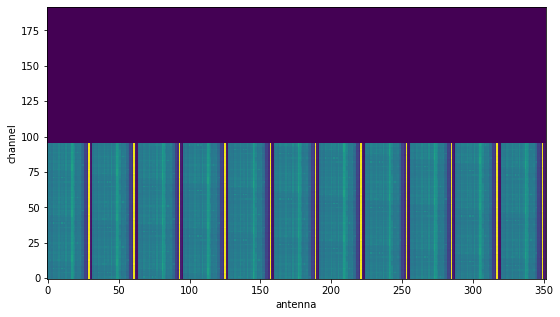

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.imshow(data[..., 0].transpose(), origin='lower', interpolation='nearest')
ax.set_xlabel('antenna')
ax.set_ylabel('channel')